In [1]:
import os 
import numpy as np
import keras
import tensorflow
import sys
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Activation
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import time

In [4]:
current_dir = os.getcwd()
train_dir = os.path.join(current_dir, 'DevanagariHandwrittenCharacterDataset/Train')
test_dir = os.path.join(current_dir, 'DevanagariHandwrittenCharacterDataset/Test')

train_datasets = os.listdir(train_dir)
test_datasets = os.listdir(test_dir)
print(test_datasets[24])
len(train_datasets)

character_32_patalosaw


46

In [5]:
# counting the data
train_dataset_count = 0
for i in train_datasets:
    data_path = os.path.join(train_dir, str(i))
    train_dataset_count += len(os.listdir(data_path))   
print(train_dataset_count)

test_dataset_count = 0
for i in test_datasets:
    data_path = os.path.join(test_dir, str(i))
    test_dataset_count += len(os.listdir(data_path))   
print(test_dataset_count)

78201
13800


In [6]:
batch_size = 32
img_rows, img_cols = 32,32
epochs = 100

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 78201 images belonging to 46 classes.
Found 13800 images belonging to 46 classes.


In [8]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),activation='relu',input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=len(train_datasets), activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [10]:
early_stop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                           patience=10,
                           verbose=1,
                           mode='max',
                           restore_best_weights=True
                          )
check_point = ModelCheckpoint(
    'Handwritten_OCR.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks=[check_point, early_stop]

In [11]:
model.compile(loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(lr=0.001)
             )

In [12]:
time1 = time.time()
history = model.fit_generator(
    train_generator, 
    validation_data=test_generator,
    epochs=epochs,
    steps_per_epoch=train_dataset_count/batch_size,
    verbose=1,
    callbacks=callbacks
    )
time2 = time.time()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2444/2443 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.8022
Epoch 00001: val_accuracy improved from -inf to 0.92957, saving model to Handwritten_OCR.h5
2444/2443 [==============================] - 104s 43ms/step - loss: 0.6904 - accuracy: 0.8022 - val_loss: 0.2315 - val_accuracy: 0.9296
Epoch 2/100
2444/2443 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9245
Epoch 00002: val_accuracy improved from 0.92957 to 0.95152, saving model to Handwritten_OCR.h5
2444/2443 [==============================] - 69s 28ms/step - loss: 0.2450 - accuracy: 0.9245 - val_loss: 0.1591 - val_accuracy: 0.9515
Epoch 3/100
2442/2443 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9452
Epoch 00003: val_accuracy improved from 0.95152 to 0.96283, saving model to Handwritten_OCR.h5
2444/2443 [==============================] - 68s 28ms/step - loss: 0.1762 

In [13]:
print(f'{(time2 - time1)/60} mins')

50.2336462299029 mins


In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

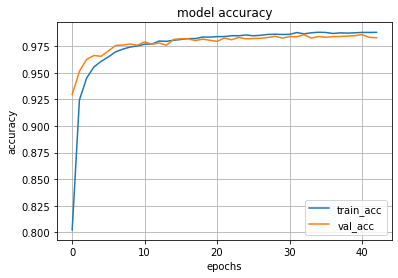

<Figure size 432x288 with 0 Axes>

In [15]:
#Accuracy plotting
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig('model_acc.png')

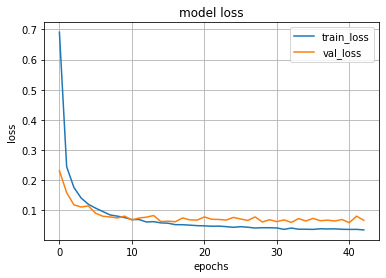

<Figure size 432x288 with 0 Axes>

In [16]:
#Accuracy plotting
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig('model_loss.png')

In [17]:
model.save('cnnmodelfordevnagarik.h5')

In [1]:
y_pred=model.predict_classes(test_dir)
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

NameError: name 'model' is not defined

In [2]:
y_pred = model.predict_classes(test_images)
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

NameError: name 'model' is not defined

In [5]:
from mlxtend.plotting import plot_confusion matrix

SyntaxError: invalid syntax (2276858649.py, line 1)

In [4]:
!pip install mlxtend

     ---------------------------------------- 1.3/1.3 MB 583.1 kB/s eta 0:00:00


In [8]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [13]:
mat = confusion_matrix(test_datasets,y_pred)
plot_confusion_matrix(conf_mat=mat)

NameError: name 'test_datasets' is not defined